Cliff Walking - SARSA vs Q-learning (Example 6.6)
creating comparison plot...


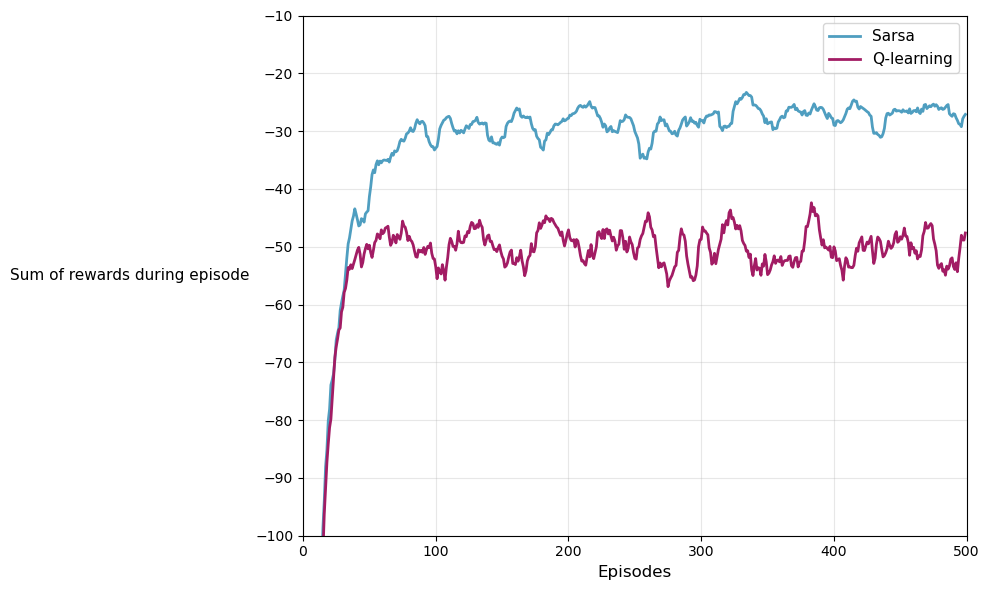

In [8]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Example 6.6 Cliff Walking
# Implementation of SARSA and Q-learning algorithms to compare their performance in the Cliff Walking environment
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt


class CliffWorld:
    """
    cliff walking grid world from Sutton & Barto example 6.6
    
    grid: 4 r x 12 c
    start: bottom-left (3,0)
    goal: bottom-right (3,11)
    cliff: bottom row from (3,1) to (3,10)
    
    actions: up, down, left, right
    rewards: -1 per step, -100 for falling off cliff
    """
    def __init__(self):
        # set up
        self.rows = 4
        self.cols = 12
        self.start_pos = (3, 0)
        self.goal_pos = (3, 11)
        self.current_pos = self.start_pos
        
        # actions: up, down, left, right
        self.action_list = ['U', 'D', 'L', 'R']
        self.action_effects = {
            'U': (-1, 0),
            'D': (1, 0),
            'L': (0, -1),
            'R': (0, 1)
        }
        
    def is_cliff(self, pos):
        """check if position is on the cliff"""
        row, col = pos
        return row == 3 and 1 <= col <= 10
    
    def is_goal(self, pos):
        """check if position is the goal"""
        return pos == self.goal_pos
    
    def reset_position(self):
        """reset to the start position"""
        self.current_pos = self.start_pos
        return self.current_pos
    
    def take_action(self, action):
        """
        execute action and return (next_state, reward, if done)
        """
        row, col = self.current_pos
        d_row, d_col = self.action_effects[action]
        
        # calculate new position
        new_row = max(0, min(self.rows - 1, row + d_row))
        new_col = max(0, min(self.cols - 1, col + d_col))
        new_pos = (new_row, new_col)
        
        # check if fell off cliff
        if self.is_cliff(new_pos):
            self.current_pos = self.start_pos
            return self.start_pos, -100, False  # not terminal, just restart
        
        # check if reached goal
        self.current_pos = new_pos
        if self.is_goal(new_pos):
            return new_pos, -1, True  # terminal state
        
        return new_pos, -1, False


def pick_action(q_vals, state, epsilon, actions):
    """
    epsilon-greedy action selection
    """
    if np.random.random() < epsilon:
        return np.random.choice(actions)
    
    # get Q values for all actions from this state
    action_values = [q_vals.get((state, a), 0.0) for a in actions]
    max_value = max(action_values)
    
    # handle ties by randomly 
    best_actions = [a for i, a in enumerate(actions) if action_values[i] == max_value]
    return np.random.choice(best_actions)


def run_sarsa(environment, n_episodes, step_size=0.5, discount=1.0, eps=0.1):
    """
    SARSA algorithm (on-policy)
    """
    q_vals = {}
    rewards_per_episode = []
    
    for ep in range(n_episodes): # for each episode
        state = environment.reset_position()
        action = pick_action(q_vals, state, eps, environment.action_list) # initial action
        
        episode_reward = 0
        
        while True:
            # take action
            next_state, reward, done = environment.take_action(action)
            episode_reward += reward
            
            if done:
                # termnianl state update
                current_q = q_vals.get((state, action), 0.0)
                q_vals[(state, action)] = current_q + step_size * (reward - current_q)
                break
            
            # choose next action using epsilon-greedy
            next_action = pick_action(q_vals, next_state, eps, environment.action_list)
            
            # SARSA update: uses the actual next action chosen
            current_q = q_vals.get((state, action), 0.0)
            next_q = q_vals.get((next_state, next_action), 0.0)
            target = reward + discount * next_q
            q_vals[(state, action)] = current_q + step_size * (target - current_q)
            
            state = next_state
            action = next_action
        
        rewards_per_episode.append(episode_reward)
    
    return q_vals, rewards_per_episode


def run_qlearning(environment, n_episodes, step_size=0.5, discount=1.0, eps=0.1):
    """
    Q-learning algorithm (off-policy)
    """
    q_vals = {}
    rewards_per_episode = []
    
    for ep in range(n_episodes):
        state = environment.reset_position()
        episode_reward = 0
        
        while True:
            # choose action using epsilon-greedy
            action = pick_action(q_vals, state, eps, environment.action_list)
            
            # take action
            next_state, reward, done = environment.take_action(action)
            episode_reward += reward
            
            if done:
                # end state update
                current_q = q_vals.get((state, action), 0.0)
                q_vals[(state, action)] = current_q + step_size * (reward - current_q)
                break
            
            # Q-learning: uses MAX of next state actions
            current_q = q_vals.get((state, action), 0.0)
            next_q_values = [q_vals.get((next_state, a), 0.0) for a in environment.action_list]
            max_next_q = max(next_q_values)
            
            target = reward + discount * max_next_q
            q_vals[(state, action)] = current_q + step_size * (target - current_q)
            
            state = next_state
        
        rewards_per_episode.append(episode_reward)
    
    return q_vals, rewards_per_episode


def smooth_rewards(rewards, window_size=20):
    """
    apply moving average smoothing to get closer to textbook figure.
    """
    smoothed = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size + 1)
        window = rewards[start_idx:i+1]
        smoothed.append(np.mean(window))
    return smoothed


def run_multiple_trials(n_runs=10, n_episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    """
    run multiple independent trials and average results for plotting
    """
    all_sarsa_rewards = []
    all_qlearn_rewards = []
    
    for run in range(n_runs):
        np.random.seed(run)  # different seed for each run so results vary
        
        env_sarsa = CliffWorld()
        env_qlearn = CliffWorld()
        
        _, rewards_sarsa = run_sarsa(env_sarsa, n_episodes, alpha, gamma, epsilon) # run SARSA
        _, rewards_qlearn = run_qlearning(env_qlearn, n_episodes, alpha, gamma, epsilon) # run Q-learning
        

        # store rewards
        all_sarsa_rewards.append(rewards_sarsa)
        all_qlearn_rewards.append(rewards_qlearn) 
        
    
    # average across all runs
    avg_sarsa = np.mean(all_sarsa_rewards, axis=0)
    avg_qlearn = np.mean(all_qlearn_rewards, axis=0)
    return avg_sarsa, avg_qlearn



def make_comparison_plot(rewards_sarsa, rewards_qlearn, n_episodes):
    """
    create plot matching textbook
    """
    plt.figure(figsize=(10, 6))
    
    #apply smoothing
    smooth_sarsa = smooth_rewards(rewards_sarsa, window_size=10)
    smooth_qlearn = smooth_rewards(rewards_qlearn, window_size=10)
    
    episode_nums = list(range(n_episodes))
    
    # plot smoothed curves
    plt.plot(episode_nums, smooth_sarsa, linewidth=2, 
             label='Sarsa', color="#4F9EC0")
    plt.plot(episode_nums, smooth_qlearn, linewidth=2, 
             label='Q-learning', color="#A21C64")
    
    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('Sum of rewards during episode', fontsize=11, 
               rotation=0, ha='right', va='center')
    plt.ylim(-100, -10)
    plt.xlim(0, 500)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cliff_walking_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("Cliff Walking - SARSA vs Q-learning (Example 6.6)")
    print("="*60)
    
    # parameters from Sutton & Barto textbook
    num_episodes = 500
    alpha = 0.5
    gamma = 1.0
    epsilon = 0.1
    num_trials = 75  # increased for a smoother average plot
    
	#comment out when submitting
    #print(f"\nsettings:")
    #print(f"  episodes: {num_episodes}")
    #print(f"  learning rate (alpha): {alpha}")
    #print(f"  discount factor (gamma): {gamma}")
    #print(f"  exploration rate (epsilon): {epsilon}")
    #print(f"  number of runs averaged: {num_trials}\n")

    # run several trials and average
    avg_sarsa, avg_qlearn = run_multiple_trials(
        n_runs=num_trials,
        n_episodes=num_episodes,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon
    )
    
    # zhow results (comment out when submitting)
    #print(f"  SARSA - average reward (last 100 episodes): {np.mean(avg_sarsa[-100:]):.1f}")
    #print(f"  Q-learning - average reward (last 100 episodes): {np.mean(avg_qlearn[-100:]):.1f}")
    
    # interpretation
    # SARSA learns a safer path (around -17 to -25) that goes up and around cliff
    # Q-learning learns optimal risky path (around -13) right along cliff edge
    # Q-learning has worse online performance (-40 to -60) due to epsilon-greedy falls
    
    # Create plot
    print("creating comparison plot...")
    make_comparison_plot(avg_sarsa, avg_qlearn, num_episodes)
